<a href="https://colab.research.google.com/github/deepandas11/Deep-Learning-with-TensorFlow-Keras-PyTorch/blob/master/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder



Source Link: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


Their latent spaces by design are continuous and therefore, it allows easy random sampling and interpolation. The encoder network does not output an encoding vector of size n, rather, it outputs two vectors of size n: a vector of **means** and a vector of **standard deviations**

They form parameters of a vector of random variables of length n, with *i*th element of $\mu$ and $\sigma$ being the mean and standard deviation of the ith random variable. 

In [0]:
from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist

import numpy as np


from keras.layers.core import Lambda
from keras import backend as K

#### Encoder Network

In [0]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [0]:
#Defining the model 

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [0]:
def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(batch_size, latent_dim), mean =0., stddev=epsilon_std)
  return z_mean + K.exp(z_log_sigma)*epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#### Decoder Network

In [0]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

#### Summary of Models

 

*   An end to end autoencoder mapping input to reconstruction
*   An encoder mapping input to latent space
*   A generator that takes point on latent space and outputs corresponding reconstructed samples.



In [0]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### Visualization of Model

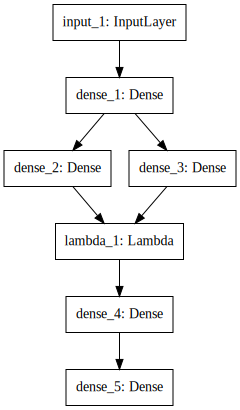

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

#### VAE on MNIST

The model has to be trained on a custom loss function

In [0]:
from keras.objectives import binary_crossentropy

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [12]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 2s 0us/step


In [13]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.2958 - val_loss: 0.2628
Epoch 2/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2631 - val_loss: 0.2627
Epoch 3/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 4/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 5/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 6/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 7/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 8/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 9/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2629 - val_loss: 0.2627
Epoch

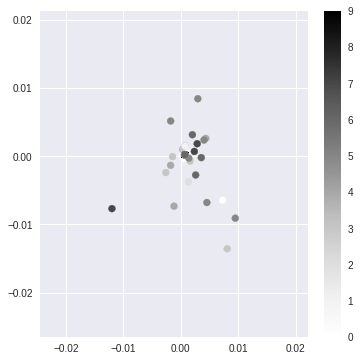

In [17]:
import matplotlib.pyplot as plt
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

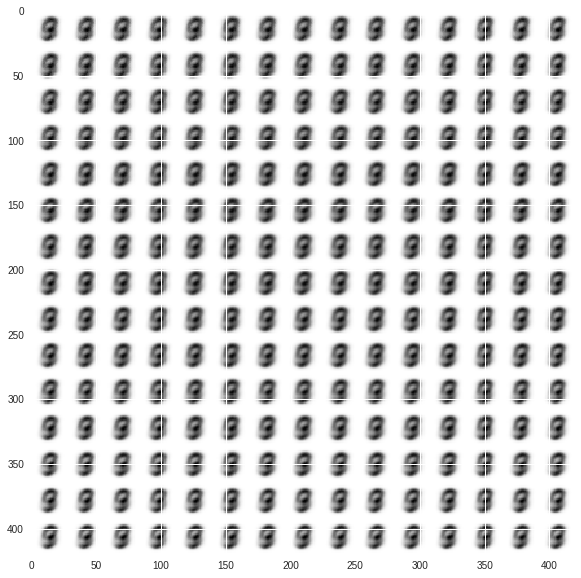

In [18]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()